In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import umap
import matplotlib as mpl
import matplotlib.pyplot as plt
import hdbscan
import seaborn as sns
from itertools import zip_longest, cycle
import matplotlib.patches as mpatches
from collections import Counter
import ast
import sqlalchemy
from sklearn.metrics import pairwise_distances

In [2]:
plt.style.use("seaborn-colorblind")

# Prepare Track Data

In [3]:
tracks_df = pd.read_csv("data/beyms_more_specific_tracks.csv", index_col="track_id")
tracks_df.head()

,genres
track_id,
4868,"['pianorock', 'soul', 'jazz', 'rb', 'neosoul',..."
2900,"['lofi', 'ambient', 'downtempo', 'triphop', 'p..."
572665,"['soul', 'blues', 'singersongwriter', 'drama']"
2897,"['downtempo', 'shoegaze', 'singersongwriter', ..."
15100,"['folkrock', 'folk', 'contemporaryfolk', 'sing..."


In [4]:
acoustic_features_df = pd.read_csv("data/acoustic_features_lfm_id.tsv", sep="\t", index_col="track_id")
acoustic_features_df = acoustic_features_df[["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "tempo", "valence", "liveness"]]
acoustic_features_df = pd.DataFrame(index=acoustic_features_df.index, columns=acoustic_features_df.columns, data=MinMaxScaler().fit_transform(acoustic_features_df))
acoustic_features_df = acoustic_features_df.loc[tracks_df.index]
acoustic_features_df.head()

C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,danceability,energy,speechiness,acousticness,instrumentalness,tempo,valence,liveness
track_id,,,,,,,,
4868,0.730731,0.769997,0.008760,0.138554,0.000000,0.419792,0.521995,0.045372
2900,0.607608,0.788997,0.006649,0.461847,0.907000,0.401404,0.157992,0.126235
572665,0.603604,0.669996,0.003588,0.004096,0.000002,0.431980,0.450995,0.110203
2897,0.863864,0.473993,0.052454,0.752008,0.183000,0.496152,0.674997,0.145273
15100,0.517518,0.491993,0.006016,0.027610,0.000032,0.554316,0.445994,0.085453


# Dimensionality Reduction with UMAP

In [5]:
latent_dimensions_df = pd.DataFrame(index=acoustic_features_df.index, data=umap.UMAP(random_state=42).fit_transform(acoustic_features_df))
latent_dimensions_df.head()

,0,1
track_id,,
4868,-3.581914,-1.859798
2900,6.813811,0.071526
572665,-2.469605,-1.049000
2897,-0.842564,-6.144903
15100,-1.141784,-1.332417


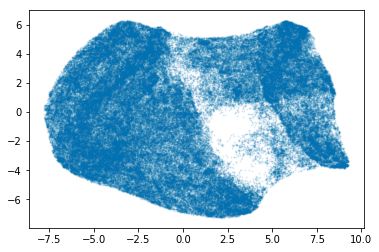

In [6]:
plt.scatter(latent_dimensions_df[0], latent_dimensions_df[1], alpha=0.1, s=1)

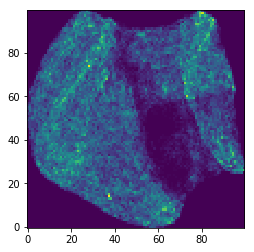

In [7]:
heatmap, _, _ = np.histogram2d(latent_dimensions_df[0], latent_dimensions_df[1], bins=100)
plt.imshow(heatmap.T, origin='lower')

# Clustering with HDBSCAN

In [8]:
def visualize_clustering(data, model):
    n_clusters = len(set(model.labels_))
    predictions = model.labels_
    
    patches = []
    mpl.rcParams["hatch.linewidth"] = 0.3
    colors = ["#0072B2", "#009E73", "#D55E00", "#CC79A7"]
    plt.figure(frameon=False)
    for c in set(model.labels_):
        if c != -1:
            cluster = data[predictions == c]
            xs = cluster[cluster.columns[0]]
            ys = cluster[cluster.columns[1]]
            
            patterns = ["//", "++", "oo", "xx"]
            patch = mpatches.Patch(label=r"$C_" + str(c+1) + "$", hatch=patterns[c], color=colors[c])
            patch.set_hatch(hatch=patterns[c])
            patches.append(patch)
            plt.scatter(xs, ys, alpha=0.7, edgecolors="None", s=20, hatch=patterns[c])
        
    plt.legend(handles=patches, loc="lower right")
    plt.show()

In [9]:
interesting_models = []
for s_min in range(1000, 1500, 25):
    model = hdbscan.HDBSCAN(min_cluster_size=s_min)
    predictions = model.fit_predict(latent_dimensions_df)
    
    if len(set(predictions))-1 == 4:
        interesting_models.append(model)
        
    print("min_cluster_size: %d, n clusters: %d" % (s_min, len(set(predictions))-1))

C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1000, n clusters: 3


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1025, n clusters: 3


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1050, n clusters: 3


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1075, n clusters: 3


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1100, n clusters: 3


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1125, n clusters: 3


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1150, n clusters: 3


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1175, n clusters: 3


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1200, n clusters: 3


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1225, n clusters: 3


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1250, n clusters: 3


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1275, n clusters: 3


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1300, n clusters: 3


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1325, n clusters: 3


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1350, n clusters: 3


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1375, n clusters: 4


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1400, n clusters: 2


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1425, n clusters: 2


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1450, n clusters: 3


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


min_cluster_size: 1475, n clusters: 3


In [10]:
# Please note that the parameters could vary slightly, since the dimensionality reduction comprises stochastic components

In [11]:
def intra_cluster_variance(data_df, model):
    predictions = model.labels_
    sses = []
    for c in set(predictions):
        mean = data_df[predictions == c].mean()
        sse = np.sum(np.power(data_df[predictions == c] - mean, 2))
        sses.append(sse)
    
    return np.sum(sses), np.mean(sses)

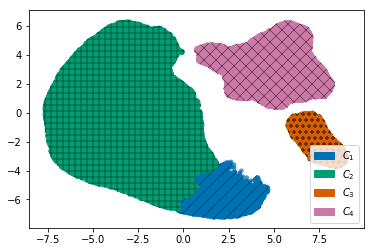

In [12]:
for model in interesting_models:
    visualize_clustering(latent_dimensions_df, model)
    intra_cluster_variance(latent_dimensions_df, model)

In [13]:
clustering_df = latent_dimensions_df.copy()
clustering_df["cluster"] = model.labels_
clustering_df.head()

,0,1,cluster
track_id,,,
4868,-3.581914,-1.859798,1
2900,6.813811,0.071526,-1
572665,-2.469605,-1.049000,1
2897,-0.842564,-6.144903,1
15100,-1.141784,-1.332417,1


In [14]:
n_tracks_per_cluster = clustering_df.groupby("cluster").size()
print("n Tracks C_1: %d" % n_tracks_per_cluster[0])
print("n Tracks C_2: %d" % n_tracks_per_cluster[1])
print("n Tracks C_3: %d" % n_tracks_per_cluster[2])
print("n Tracks C_4: %d" % n_tracks_per_cluster[3])
print("%d Tracks couldn't be classified and lie in between clusters" % n_tracks_per_cluster[-1])

n Tracks C_1: 12148
n Tracks C_2: 92798
n Tracks C_3: 7629
n Tracks C_4: 30379
14490 Tracks couldn't be classified and lie in between clusters


# Visualize Distribution of Acoustic Features

In [15]:
def zip_longest_cycle(A, B):
    zip_list = zip(A, cycle(B)) if len(A) > len(B) else zip(cycle(A), B)
    return zip_list

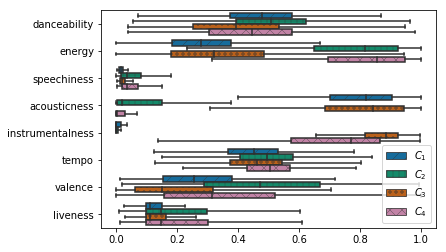

In [16]:
df = acoustic_features_df
df = acoustic_features_df.stack().reset_index()
df.columns = ["track_id", "feature", "value"]
df = df.merge(clustering_df, left_on="track_id", right_index=True)
g = sns.boxplot(data=df[df["cluster"] != -1], x="value", y="feature", hue="cluster", showfliers=False)
g.legend_.set_title("")

patterns = ["//", "++", "oo", "xx"]
for hatch, patch in zip_longest_cycle(patterns, g.artists):
    patch.set_hatch(hatch)
    
for hatch, bar in zip_longest_cycle(patterns, g.patches):
    bar.set_hatch(hatch)

plt.legend()
labels = [r"$C_1$", r"$C_2$", r"$C_3$", r"$C_4$"]
for t, l in zip(g.legend_.texts, labels):
    t.set_text(l)
plt.ylabel("")
plt.xlabel("")
plt.grid(False)

# Visualize Distribution of Genres

In [17]:
genre_annotations_df = pd.read_csv("data/beyms_more_specific_tracks.csv", index_col="track_id")
genre_annotations_df["genres"] = genre_annotations_df["genres"].apply(ast.literal_eval)
genre_annotations_df.head()

,genres
track_id,
4868,"[pianorock, soul, jazz, rb, neosoul, blues, si..."
2900,"[lofi, ambient, downtempo, triphop, postpunk, ..."
572665,"[soul, blues, singersongwriter, drama]"
2897,"[downtempo, shoegaze, singersongwriter, indiep..."
15100,"[folkrock, folk, contemporaryfolk, singersongw..."


In [18]:
idf_scores_df = pd.read_csv("data/genre_idf_scores.csv", index_col="genre")
idf_scores_df.head()

,idf
genre,
rock,0.404844
pop,0.674384
metal,0.719958
electronic,0.740530
alternativerock,0.755070


In [19]:
too_general_genres = idf_scores_df.head(6).index.tolist()
too_general_genres

['rock', 'pop', 'metal', 'electronic', 'alternativerock', 'indierock']

In [20]:
tf_idf_scores_df = pd.DataFrame()
for cluster, data in genre_annotations_df.merge(clustering_df[["cluster"]], left_index=True, right_index=True).groupby("cluster"):
    if cluster != -1:
        term_frequencies = Counter(dict.fromkeys(idf_scores_df.index, 0))
        for _, counts in data.iterrows():
            term_frequencies = Counter(term_frequencies + Counter(counts.values[0]))
        tf_idf = Counter({genre: idf_scores_df.loc[genre].values[0] * term_frequencies[genre] for genre in idf_scores_df.index})
        tf_idf_df = pd.DataFrame.from_dict(tf_idf, orient="index", columns=["tf-idf"]).sort_values(by="tf-idf", ascending=False)
        tf_idf_df.index.name = "genre"
        tf_idf_df["cluster"] = cluster
        tf_idf_scores_df = tf_idf_scores_df.append(tf_idf_df)

In [21]:
tf_idf_scores_df = tf_idf_scores_df[~tf_idf_scores_df.index.isin(too_general_genres)]

Text(0.5, 0, 'Summed-up genre IDF-scores')

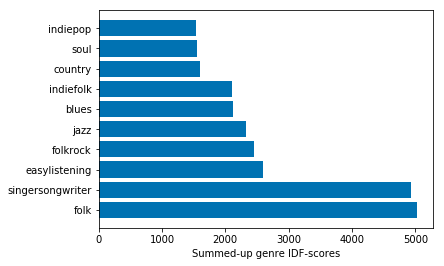

In [22]:
top10_df = tf_idf_scores_df[tf_idf_scores_df["cluster"] == 0].sort_values(by="tf-idf", ascending=False).head(10)
plt.barh(top10_df.index, top10_df["tf-idf"])
plt.xlabel("Summed-up genre IDF-scores")

Text(0.5, 0, 'Summed-up genre IDF-scores')

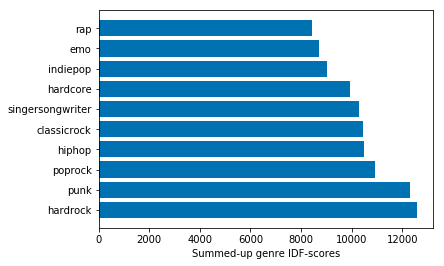

In [23]:
top10_df = tf_idf_scores_df[tf_idf_scores_df["cluster"] == 1].sort_values(by="tf-idf", ascending=False).head(10)
plt.barh(top10_df.index, top10_df["tf-idf"])
plt.xlabel("Summed-up genre IDF-scores")

Text(0.5, 0, 'Summed-up genre IDF-scores')

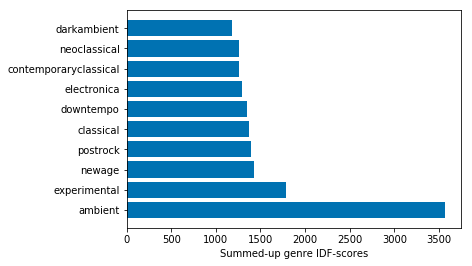

In [24]:
top10_df = tf_idf_scores_df[tf_idf_scores_df["cluster"] == 2].sort_values(by="tf-idf", ascending=False).head(10)
plt.barh(top10_df.index, top10_df["tf-idf"])
plt.xlabel("Summed-up genre IDF-scores")

Text(0.5, 0, 'Summed-up genre IDF-scores')

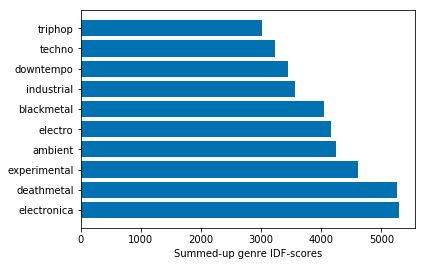

In [25]:
top10_df = tf_idf_scores_df[tf_idf_scores_df["cluster"] == 3].sort_values(by="tf-idf", ascending=False).head(10)
plt.barh(top10_df.index, top10_df["tf-idf"])
plt.xlabel("Summed-up genre IDF-scores")

# Visualize Relative Genre Frequency

In [26]:
db_options_df = pd.read_csv("db_credentials.txt", sep="=", header=None)
db_options_df.columns = ["variable", "value"]
db_options_df = db_options_df.apply(lambda col: col.str.strip())
db_options_df.set_index("variable", inplace=True)
db_options = db_options_df["value"].to_dict()
db_options

{'DB_PATH': '@localhost:3306/music_recommender_db',
 'DB_USERNAME': 'root',
 'DB_PW': '1234'}

In [27]:
connection = sqlalchemy.create_engine('mysql+pymysql://' + db_options["DB_USERNAME"] + ":" + db_options["DB_PW"] + db_options["DB_PATH"])

In [28]:
beyms = pd.read_csv("data/beyms.csv")["user_id"].tolist()

In [29]:
events_df = pd.read_sql(con=connection, sql="SELECT user_id, track_id FROM events WHERE user_id IN " + str(tuple(beyms)) + " AND track_id IN " + str(tuple(tracks_df.index)))
events_df.head()

C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\pymysql\cursors.py:170: Warning: (1366, "Incorrect string value: '\\xE4ische...' for column 'VARIABLE_VALUE' at row 1")
  result = self._query(query)


,user_id,track_id
0,31435741,53
1,31435741,53
2,31435741,53
3,31435741,53
4,31435741,53


In [30]:
events_with_genres_df = events_df.merge(clustering_df[["cluster"]], left_on="track_id", right_on="track_id").merge(genre_annotations_df, left_on="track_id", right_index=True)
events_with_genres_df.head()

,user_id,track_id,cluster,genres
0,31435741,53,1,"[soul, rap, poprock, softrock, rhythmandblues,..."
1,31435741,53,1,"[soul, rap, poprock, softrock, rhythmandblues,..."
2,31435741,53,1,"[soul, rap, poprock, softrock, rhythmandblues,..."
3,31435741,53,1,"[soul, rap, poprock, softrock, rhythmandblues,..."
4,31435741,53,1,"[soul, rap, poprock, softrock, rhythmandblues,..."


In [31]:
events_with_genres_df["genres"] = events_with_genres_df["genres"].apply(Counter)

In [32]:
genres_per_cluster_df = events_with_genres_df.groupby("cluster")["genres"].sum().to_frame()
genres_per_cluster_df.head()

,genres
cluster,
-1,"{'downtempo': 67402, 'triphop': 45992, 'postpu..."
0,"{'newwave': 8774, 'synthpop': 6174, 'britpop':..."
1,"{'soul': 215637, 'rap': 187961, 'poprock': 449..."
2,"{'progressiverock': 16292, 'easylistening': 22..."
3,"{'bluesrock': 12806, 'garagerock': 25225, 'blu..."


In [33]:
n_events_per_cluster_df = events_with_genres_df.groupby("cluster").size().to_frame()
n_events_per_cluster_df

,0
cluster,
-1,422612
0,330072
1,3137336
2,195289
3,830865


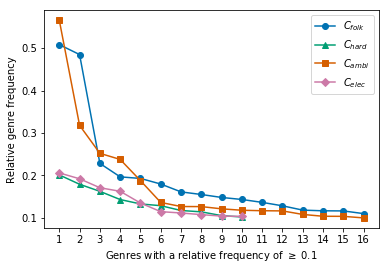

In [36]:
markers = ["o", "^", "s", "D"]
colors = ["#0072B2", "#009E73", "#D55E00", "#CC79A7"]
names = [r"$C_{folk}$", r"$C_{hard}$", r"$C_{ambi}$", r"$C_{elec}$"]

max_genres = 0
for c, data in genres_per_cluster_df.iterrows():
    if c != -1:
        sorted_occs = sorted(dict(data["genres"]).items(), key=lambda tup: tup[1])[::-1]
        ys = list(zip(*sorted_occs))[1]
        ys = np.array(ys) / n_events_per_cluster_df.loc[c].values[0]
        ys = ys[np.where(ys >= 0.1)]
        plt.plot(range(len(ys)), ys, "-o", label=names[c], marker=markers[c], color=colors[c])
        if len(ys) > max_genres:
            max_genres = len(ys)
            plt.xticks(list(range(len(ys))), np.array(list(range(len(ys)))) + 1)
    
plt.legend()
plt.ylabel("Relative genre frequency")
plt.xlabel(r"Genres with a relative frequency of $\geq$ 0.1")
plt.grid(False)
plt.show()

# Save Clustering Data

In [35]:
clustering_df.to_csv("data/track_clustering.csv", index=True)